In [ ]:
# Importing the requisite packages
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import scipy

from plotnine import *
from numpy.linalg import inv, det
from scipy import stats as sts
from shapely.geometry import Point, Polygon



---



# <font color='orange'> Task 0: read data </font>

Suppose that in the data below, each dot represents a car break-in in Toronto. You own a real-estate company in Toronto and your client asked you to identify areas with high potential for investment and your client identified that areas with higher than average car break-ins tend to be less profitable. Help your client identify regions of Toronto where they should invest.

In [ ]:
df = pd.read_csv(("KDE_data.csv"))
df.head(3)

,latitude,longitude,coords
0,43.685990,-79.444760,POINT (-79.44476 43.68599)
1,43.764010,-79.326120,POINT (-79.32611959885489 43.764009943460096)
2,43.677025,-79.564677,POINT (-79.5646773 43.67702480000001)


In [ ]:
# Convert the pandas dataframe to a geopandas dataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs=4326))
fig = px.scatter_mapbox(gdf,
                        lat = df.latitude,
                        lon = df.longitude,
                        center={"lat": np.median(df.latitude), "lon": np.median(df.longitude)},
                        mapbox_style="carto-positron",
                        color_continuous_scale='Sunset',
                        zoom=9.5,
                        height=700,
                        width=800
                      )
fig.show()



---



In [ ]:
#Task 1: Kernel Density Estimation
#Use a 2D Gaussian Kernel to estimate the probability of a car break-in for each point in the dataframe 'df' we created above. Use Silverman's rule of thumb to estimate the bandwidth matrix.

'''
f_H(x): is the kernel-estimated density - your goal is to calculate f_H(x) for each point in df
n: number of points
K_H(x): is the d-dimensional Gaussian Kernel (in this problem d=2)
x: is a 2-dimensional vector representing the point where you want to estimate f_H(x)
x_i: is a 2-dimensional vector where you are centering the the kernel
H: is the bandwidth matrix (sometimes called the covariance matrix)
'''

In [ ]:
# Suggested steps:

# Step 1:
# Build the bandwidth matrix, H, based on Silverman's rule
# Calculate the determinant of H using this function from numpy (already imported): det(H)
# Calculate the inverse of H using this function from numpy (already imported): inv(H)


# Step 2:
# Create a function that calculates the kernel value, K_H(x), given a 2-d vector x


# Step 3:
# Calculate the kernel density, f_H(x), for each point in df
# Save the value of f_H(x) for each point in the matrix df as a column named 'f'
# Use the code below to plot the densities

In [ ]:
# Step 1:
# Build the bandwidth matrix, H, based on Silverman's rule
d = 2
n = len(df)
sigma_i = [df['latitude'].std(),df['longitude'].std()] #[0.051798980328349564, 0.07427557757406]
diagonal = [((4 / (d + 2)) ** (1 / (d + 4))) * (n ** (-1 / (d + 4))) * i for i in sigma_i]
H_matrix = (np.diag(diagonal))**2  #remember power 2 :)))
# Calculate the determinant of H
det_H = np.linalg.det(H_matrix)
# Calculate the inverse of H
inv_H = np.linalg.inv(H_matrix)

# Step 2:
# Create a function that calculates the kernel value, K_H(x), given a 2-d vector x
def gaussian_kernel(x_diff, d, det_H, inv_H):
  return ((2 * np.pi)**(-d / 2)) * (det_H**-0.5) * np.exp(-0.5*np.dot(np.dot(x_diff,inv_H), x_diff.T))

# Step 3:
# Calculate the kernel density, f_H(x), for each point in df
def kernel_density_estimation(x, df_points, d, det_H, inv_H):
  density = 0
  for x_i in df_points:
    x_diff = x - x_i
    density += gaussian_kernel(x_diff, d, det_H, inv_H)
  return density/len(df_points)

df_points = df[['latitude', 'longitude']].values
densities = []
for _, row in df.iterrows():
  x = row[['latitude', 'longitude']].values
  densities.append(kernel_density_estimation(x, df_points, d, det_H, inv_H))

df['f'] = densities

In [ ]:
# Convert the pandas dataframe to a geopandas dataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs=4326))
fig = px.scatter_mapbox(gdf,
                        lat = df.latitude,
                        lon = df.longitude,
                        center={"lat": np.median(gdf.latitude), "lon": np.median(gdf.longitude)},
                        mapbox_style="carto-positron",
                        color = 'f',
                        color_continuous_scale='Sunset_r',
                        zoom=9.5,
                        height=700,
                        width=800
                      )
fig.show()



---



# <font color='orange'> Task 2: Use the kernel-estimated densities to estimate probabilities </font>

The kernel density estimates you calculated above are akin to a probability density function. The values calculated at each point are *not* probabilities. To estimate the probability you have to integrate f_H(x) over an area. However, point do not have area! We have to find a way around this problem.

Here, we will create a grid with small cells and overlay data on our area of interest (Toronto). Each grid cell has an area. We will calculate f_H(x) for one point inside this cell and assume that that value represents the density for any point inside the cell. Then, we can calculate the probability of car break-in for that cell as $f_H(x) * \delta x * \delta y$ where $\delta x$ and $\delta y$ represent the width and height of each cell.

In [ ]:
# Suggested steps

# Step 0:
# Create a dataframe named df_grid


# Step 1:
# Create a 40x40 grid of (lon,lat) points bounded by the minimum and maximum latitudes in the data
# Save the longitudes as df_grid['lon']
# Save the latitudes as df_grid['lat']
'''
                  ______max lon, max lat
                  |     |
                  |     |
min lon, min lat  |_____| 40x40
'''
min_lat, max_lat = df['latitude'].min(), df['latitude'].max()
min_lon, max_lon = df['longitude'].min(), df['longitude'].max()
lat_grid = np.linspace(min_lat, max_lat,40)
lon_grid = np.linspace(min_lon, max_lon, 40)
df_grid = pd.DataFrame({'lat': np.repeat(lat_grid, len(lon_grid)),
                       'lon': np.tile(lon_grid, len(lat_grid))})
# Step 2:
# Calculate the f_H(x) for each point in the grid
# Save the densities as df_grid['f']

grid_points = df_grid[['lat', 'lon']].values
# Function to calculate kernel density for grid points
def calculate_grid_densities(grid_points, df_points, d, det_H, inv_H):
    densities = []
    for grid_point in grid_points:
        density = kernel_density_estimation(grid_point, df_points, d, det_H, inv_H)
        densities.append(density)
    return densities

# Calculate densities for all grid points
grid_densities = calculate_grid_densities(grid_points, df_points, d, det_H, inv_H)

# Save the densities in the df_grid dataframe
df_grid['f'] = grid_densities

# Step 3:
# Calculate the probability of car break-in for each cell
# Show that the volume under f_H(x) is approximates 1
delta_y = (lat_grid[1] - lat_grid[0]) #size of each grid, length
delta_x = (lon_grid[1] - lon_grid[0]) #size of each grid, width
cell_area = delta_x * delta_y
df_grid['P'] = df_grid['f'] * cell_area

print(f"volum under f_H(x) is equal {df_grid['P'].sum()}")
# Step 4:
# Plot the probabilities using the code below
### it is in the next cell

# Step 4:
# Find points in the grid where the probability of car break-in is below average

volum under f_H(x) is equal 0.99036451367497


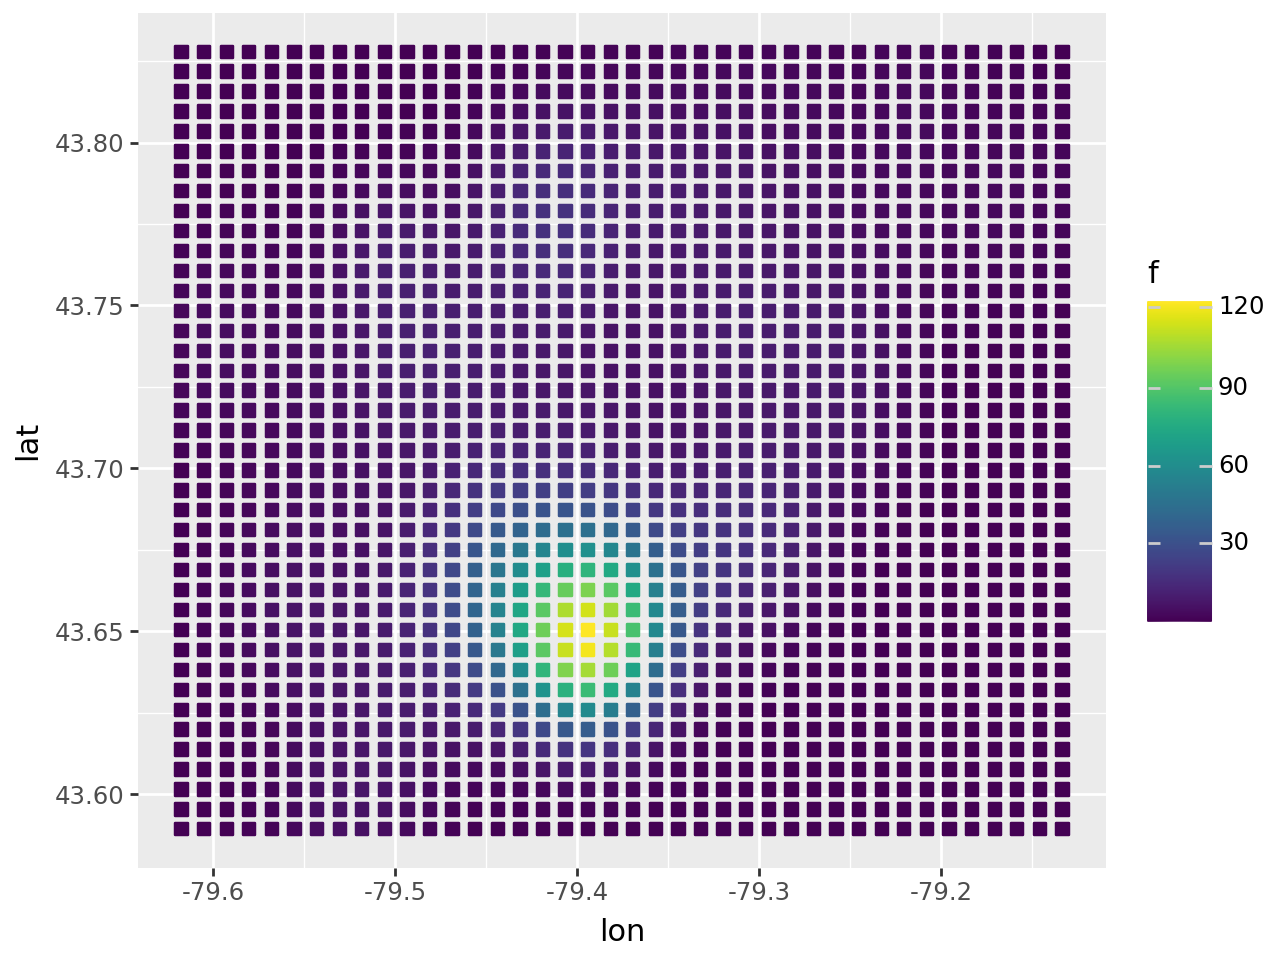

In [ ]:
'''
Solution cell
'''
# Plotting the grid
ggplot(df_grid,aes(x='lon', y='lat', color='f')) + geom_point(size=2, shape='s')

In [ ]:
# Some code was here
print('The volume under the 2d estimated density is', df_grid['P'].sum())

The volume under the 2d estimated density is 0.99036451367497


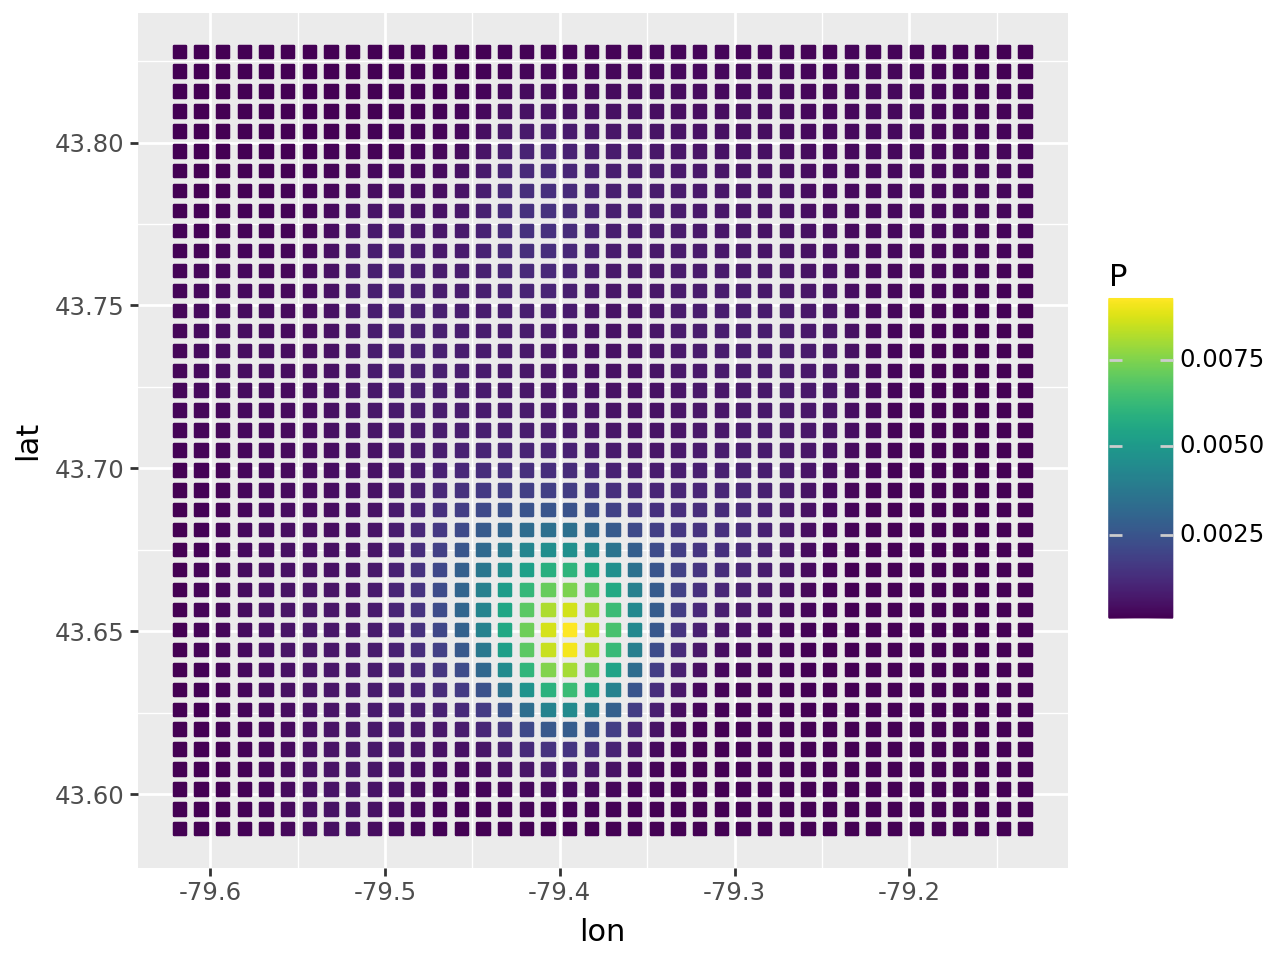

In [ ]:
'''
Solution cell
'''
# Plot the probability for each cell
ggplot(df_grid,aes(x='lon', y='lat', color='P')) + geom_point(size=2, shape='s')

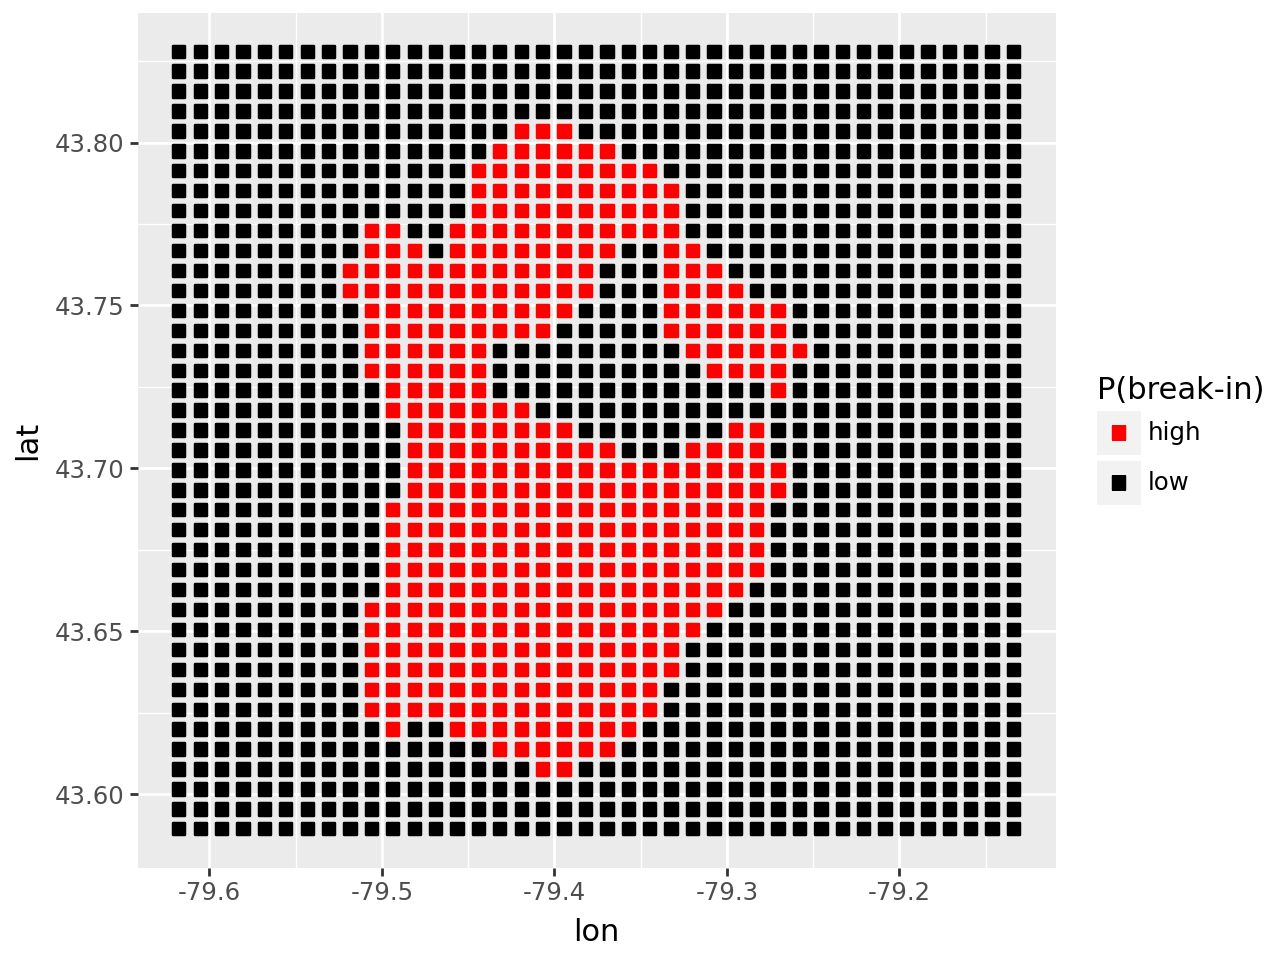

In [ ]:
'''
Solution cell
'''
# Areas with high probability of break-in
df_grid['P(break-in)'] = df_grid['P'].apply(lambda x: 'high' if x > df_grid['P'].mean() else 'low')
ggplot(df_grid,aes(x='lon', y='lat', color='P(break-in)')) + geom_point(size=2, shape='s') + scale_color_manual(values=['red','black'])

# With this grid and the coordinates of potential investment, you can inform your client whether it is good investment or not.



---



---

